# Analysis and Visulaization

Now that the data has been cleaned, null values imputed, outliers removed etc, it is far easier to analyse the data correctly


## Necessary imports

In [1]:
import pandas as pd

#importing my classes
from dataFrameInfo import Data_FrameInfo
from data_Transform import DataTransform
from dataFrameTransform import Data_FrameTransform
from plotter import Plotter

#importing dataframes
df = pd.read_csv('dfnonulls.csv')
normalised = pd.read_csv('dfnoskew.csv')

#instantiating classes
transform = DataTransform()
query = Data_FrameInfo()
visual = Plotter(df)


## Current state of the loans

### Working out percentage of loans fully recovered

In this section, I will suummarise what percentage of the loans have been currently recovered compared to the total amount to be paid over the loans term including interest.

Additionally I will calculate how much will be paid back in 6 months time with interest and visualise my results.

#### Current position

In order to assess this, I need to calculate the following:

1) The amount of money actually recovered. This will be simply the total payments
2) The amount of money that would be recovered if everyone paid in full. This will be the amount of installments * the amount of each installment

In [2]:
#calculate totals recovered by funded amount and by investor
total_recovered_fun = df['total_payment'].sum()
total_recovered_inv = df['total_payment_inv'].sum()

#calculate total amounts loaned out and invested
total_funded_inv = df['funded_amount_inv'].sum()
total_funded = df['funded_amount'].sum()

#calculate totals expected by funded amount and by investor
df['total_expected'] = df['instalment'] * df['term(mths)']

total_expected = df['total_expected'].sum()

#print percentages by expected funded amount and by investor
pct_recovered_expfun = round(total_recovered_fun/total_expected*100, 2)
pct_recovered_expinv = round(total_recovered_inv/total_expected*100, 2)
print(f'The % of expected funded amount recovered is: {pct_recovered_expfun}%')
print(f'The % of expected invested amount recovered is: {pct_recovered_expinv}%')

#print percentages of loaned amounts and invested amounts
pct_recovered_fun = round(total_recovered_fun/total_funded*100, 2)
pct_recovered_inv = round(total_recovered_inv/total_funded_inv*100, 2)
print(f'The % of funded amount recovered is: {pct_recovered_fun}%')
print(f'The % of invested amount recovered is: {pct_recovered_inv}%')

The % of expected funded amount recovered is: 70.61%
The % of expected invested amount recovered is: 68.92%
The % of funded amount recovered is: 91.78%
The % of invested amount recovered is: 91.02%


It seems although the bank olny recoved about 70% of what it was expecting to recover, it has recovered about 90% of what was loaned out and invested

,Funding,Percent,Percent Expected
0,Investor,91.78,70.61
1,Total,91.02,68.92


<Axes: xlabel='Funding', ylabel='% Recovered'>

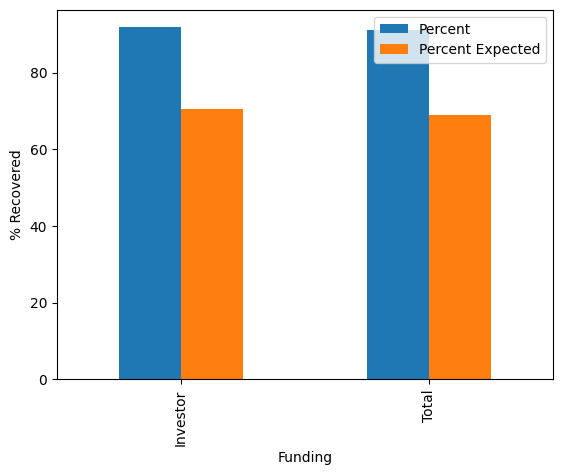

In [3]:
data = {'Funding': ['Investor', 'Total'],
        'Percent': [pct_recovered_fun, pct_recovered_inv],
        'Percent Expected':[pct_recovered_expfun, pct_recovered_expinv]}

# Create a Pandas DataFrame
df_bar = pd.DataFrame(data)
display(df_bar)

df_bar.plot(x="Funding", y=["Percent","Percent Expected"], kind="bar", ylabel="% Recovered") 

#### Position  in 6 months

For this, any fully paid loans and charged off loans need to be excluded from consideration. Only those current loans and (potentially) those in default not yet charged off are going to bring in more money.

In [4]:
df_current = df.loc[df['loan_status'] == 'Current']
df_current = df_current.reset_index(drop=True)
print(df_current)

       Unnamed: 0        id  member_id  loan_amount  funded_amount  \
0               0   8588502   10330306         5000           5000   
1               4   8148555    4640566        12000          12000   
2               6   8977266   10779272        10000          10000   
3              11   8629345   10401156         4375           4375   
4              12  38361412   41145143         4000           4000   
...           ...       ...        ...          ...            ...   
19263       54213   7055315    8717456        11400          11400   
19264       54214   7049426    8711455         7800           7800   
19265       54215   6805066    8427208        16000          16000   
19266       54222   8627224   10399185         7200           7200   
19267       54223   8148232    9890178        12000          12000   

       funded_amount_inv  term(mths)  int_rate  instalment grade  ...  \
0                 5000.0          36      7.90      156.46     A  ...   
1            

In [5]:
#creates new column with 6 months worth of payments added to the existing payments
df_current['total_payment_six'] = df_current['total_payment'] + 6 * df_current['instalment']

#calculate amount to be added to previously exitisng total
payments_to_add = df_current['total_payment_six'].sum()

#edit preexisting totals 

total_recovered_fun = total_recovered_fun + payments_to_add
total_recovered_inv = total_recovered_inv + payments_to_add

#print percentages by expected funded amount and by investor
pct_recovered_expfun = round(total_recovered_fun/total_expected*100, 2)
pct_recovered_expinv = round(total_recovered_inv/total_expected*100, 2)
print(f'The % of expected funded amount recovered is: {pct_recovered_expfun}%')
print(f'The % of expected invested amount recovered is: {pct_recovered_expinv}%')

#print percentages of loaned amounts and invested amounts
pct_recovered_fun = round(total_recovered_fun/total_funded*100, 2)
pct_recovered_inv = round(total_recovered_inv/total_funded_inv*100, 2)
print(f'The % of funded amount recovered is: {pct_recovered_fun}%')
print(f'The % of invested amount recovered is: {pct_recovered_inv}%')

The % of expected funded amount recovered is: 99.02%
The % of expected invested amount recovered is: 97.33%
The % of funded amount recovered is: 128.7%
The % of invested amount recovered is: 128.53%


These extra payments make a huge different to the state of the loans. The bank has recovered more than 90% of what it expected and has now made a profit on the amount they loaned out

,Funding,Percent,Percent Expected
0,Investor,128.70,99.02
1,Total,128.53,97.33


<Axes: xlabel='Funding', ylabel='% Recovered'>

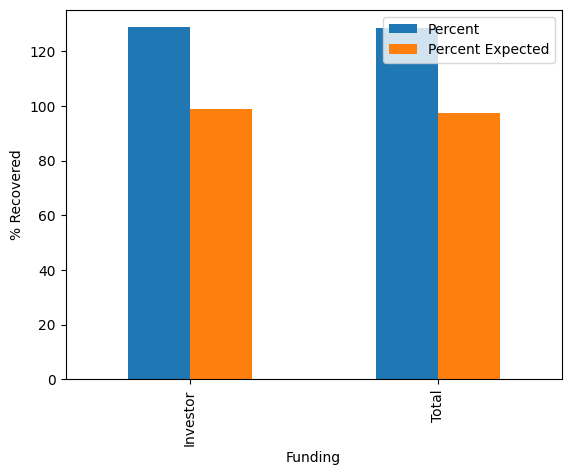

In [6]:
data = {'Funding': ['Investor', 'Total'],
        'Percent': [pct_recovered_fun, pct_recovered_inv],
        'Percent Expected':[pct_recovered_expfun, pct_recovered_expinv]}

# Create a Pandas DataFrame
df_bar = pd.DataFrame(data)
display(df_bar)

df_bar.plot(x="Funding", y=["Percent","Percent Expected"], kind="bar", ylabel="% Recovered") 

### Calculating Loss

The company wants to check what percentage of loans have been a loss to the company:


Loans marked as Charged Off in the loan_status column represent a loss to the company.


Calculate the percentage of charged off loans and the total amount that was paid towards these loans before being charged off.

In [7]:
#extract those loans marked as Charged off
df_charged_off = df.loc[df['loan_status']== "Charged Off"]
df_charged_off.reset_index

#count rows for percentage required
no_of_loans = len(df)
no_of_charged_off = len(df_charged_off)

#calculating percentage
pct_charged_off = round(no_of_charged_off/no_of_loans*100, 2)

print(f'The % of loans charged off is: {pct_charged_off}%')

The % of loans charged off is: 10.27%


It appears that about 1 in 10 loans was charged off by the bank. Lets visualize this

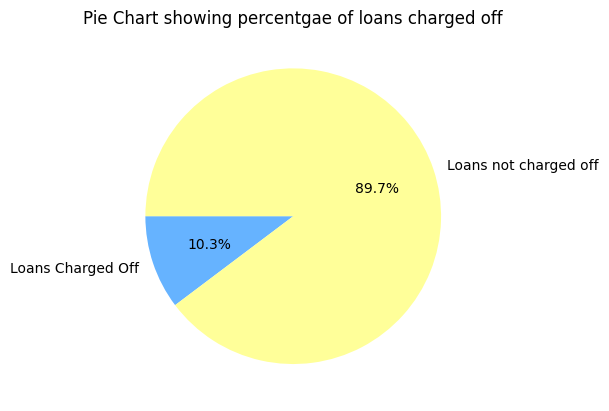

In [8]:
loans_not_charged_off = len(df)-len(df_charged_off)

visual.pie_chart(["Loans Charged Off", "Loans not charged off"], [no_of_charged_off,loans_not_charged_off], "Pie Chart showing percentgae of loans charged off")

The total amount paid towards these charged off loans can be summarised simply with:

In [9]:
total_paid_charged_off = round(df_charged_off['total_payment'].sum(),2)
print(f'The total amount paid on loans before they were charged off is : ${total_paid_charged_off}')

The total amount paid on loans before they were charged off is : $37400589.04


### Calculating projected loss

It helps to visualize this as a proportion of what was expected

The total amount lost on loans  charged off is : $64668770.84


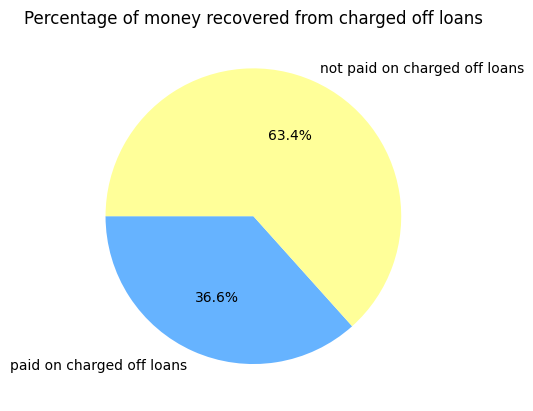

In [10]:
amount_lost = round(df_charged_off['total_expected'].sum() - df_charged_off['total_payment'].sum(),2)
print(f'The total amount lost on loans  charged off is : ${amount_lost}')

visual.pie_chart(["paid on charged off loans","not paid on charged off loans"],[total_paid_charged_off, amount_lost], "Percentage of money recovered from charged off loans")

From this Pie Chart, it seems that when it comes to charged off loans, the bank only recovers just over a third of their money in payments. However, this does not include any fees recovered to lessen the loss.

In [11]:
%history -g

 1/1:

from selenium import webdriver
import time
from selenium.webdriver.common.by import By

driver = webdriver.Firefox() 
URL = "https://www.zoopla.co.uk/new-homes/property/london/?q=London&results_sort=newest_listings&search_source=new-homes&page_size=25&pn=1&view_type=list"
driver.get(URL)
time.sleep(10) # Wait a couple of seconds, so the website doesn't suspect you are a bot
try:
    driver.switch_to_frame('gdpr-consent-notice') # This is the id of the frame
    accept_cookies_button = driver.find_element(By.XPATH, '//*[@id="save"]')
    accept_cookies_button.click()

except AttributeError: # If you have the latest version of Selenium, the code above won't run because the "switch_to_frame" is deprecated
    driver.switch_to.frame('gdpr-consent-notice') # This is the id of the frame
    accept_cookies_button = driver.find_element(By.XPATH, '//*[@id="save"]')
    accept_cookies_button.click()

except:
    pass # If there is no cookies button, we won't find it, so we can pass

drive

### Calculating potential loss

There are customers who are currently behind with their loan payments. This subset of customers represent a risk to company revenue.


What percentage do users in this bracket currently represent?

Calculate the total amount of customers in this bracket and how much loss the company would incur if their status was changed to Charged Off.

What is the projected loss of these loans if the customer were to finish the full loan term?


If customers that are late on payments converted to Charged Off, what percentage of total expected revenue do these customers and the customers who have already defaulted on their loan represent?

In [16]:
#Filter those records that are behind in payments
df_in_default = df.loc[(df['loan_status']== 'Late (16-30 days)')| (df['loan_status']== 'Late (31-120 days)')]

#Find total payments of these records
current_payments = df_in_default['total_payment'].sum()

#Project expected payment of these records. This was previously calculated in another cell so only needs to be summed here
expected_income = df_in_default['total_expected'].sum()

#Find possible loss
poss_loss = round(expected_income - current_payments, 2)

# Calculating the percentage of users in risky loans bracket as a percentage of all loans.
print(f'Percentage of users in the risky loans bracket as a percentage of all loans: {round(100 * df_in_default.shape[0]/df.shape[0], 2)}%\n')

# Calculating the total amount of customers in this bracket
print(f'The total amount of customers in this bracket: {round(df_in_default.shape[0], 2)}')

print(f'The potential loss  on loans if charged off is : ${poss_loss}')



Percentage of users in the risky loans bracket as a percentage of all loans: 1.26%

The total amount of customers in this bracket: 686
The potential loss  on loans if charged off is : $7316814.49


In [18]:
# Changing the loan status customers who are currently behind with their loan payments to Charged Off.
df_to_charge_off = df.copy()
# Applying the condition
df_to_charge_off.loc[df_to_charge_off["loan_status"] == "Default", "loan_status"] = 'Charged Off'
df_to_charge_off.loc[df_to_charge_off["loan_status"] == "Late (16-30 days)", "loan_status"] = 'Charged Off'
df_to_charge_off.loc[df_to_charge_off["loan_status"] == "Late (31-120 days)", "loan_status"] = 'Charged Off'

# Filter for charged off loans
df_to_charge_off = df_to_charge_off.loc[df_to_charge_off['loan_status'] == 'Charged Off']
df_to_charge_off = df_to_charge_off.reset_index(drop=True)

#find expected revenue from late paying customers
df_in_default = df.loc[(df['loan_status']== 'Default)')| (df['loan_status']== 'Late (16-30 days)')| (df['loan_status']== 'Late (31-120 days)')]
amount_exp = df_in_default['total_expected'].sum()
pct_defaulted = round(amount_exp/total_expected*100,2)
print(f'The percentage of total expected income represented by those late or in default is : {pct_defaulted}%')

#including those already charged off
amount_co_exp = df_to_charge_off['total_expected'].sum()
pct_defaulted = round(amount_co_exp/total_expected*100,2)
print(f'The percentage of total expected income represented by those late or in default INCLUDING those already charged off is : {pct_defaulted}%')

#find loss from everyone in default being charged off
total_payments = df_in_default['total_payment'].sum()
loss_if_charged_off = round(amount_exp - total_payments,2)

print(f'The projected loss of these loans if the customer were to finish the full loan term is : ${loss_if_charged_off}')

The percentage of total expected income represented by those late or in default is : 1.53%
The percentage of total expected income represented by those late or in default INCLUDING those already charged off is : 12.65%
The projected loss of these loans if the customer were to finish the full loan term is : $7316814.49
